In [259]:
import sys
import paths

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [260]:
data_home = paths.LOCAL_DIR
lats = ["26N", "30S", "55S", "60S"]

In [261]:
lat = lats[3]
inputs = xr.open_dataset(f"{data_home}/solodoch_data_minimal/{lat}.nc")
inputs

<xarray.Dataset>
Dimensions:    (time: 288, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2015-12-16T12:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

In [262]:
outputs = xr.open_dataset(f"{data_home}/streamfunctions_ecco/{lat}/PSI_residual{lat}.nc")
outputs

<xarray.Dataset>
Dimensions:  (k: 50, lat: 1, time: 312)
Coordinates:
    Z        (k) float32 ...
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * lat      (lat) int32 -60
  * time     (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    trsp_z   (time, k, lat) float64 ...
    psi_moc  (time, k, lat) float64 ...
    moc      (time, lat) float64 ...

In [263]:
date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range)

Date range to align to: ('1992-01-16', '2015-12-16')


In [285]:
# apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=True,
                              remove_trend=True,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, keep_coords=["longitude", "time"])

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=True,
                               remove_trend=True,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
X = pp_data_np
# Necessary step to do convolutions along the right axis with pytorch tensors!
X = X.transpose(0,2,1)

y = strength_np

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'longitude', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (288, 720, 5)

Inputs shape: (288, 5, 720)
Outputs shape: (288,)


In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device)
Yt_train = t.tensor(y_train, device=device)
Xt_test = t.tensor(X_test, device=device)
Yt_test = t.tensor(y_test, device=device)

device: cpu


In [287]:
import importlib
from models import train, SimDataset, CNN1D, CNN2D, CNN3D

importlib.reload(train)
importlib.reload(CNN1D)
importlib.reload(SimDataset)

<module 'models.SimDataset' from 'C:\\Users\\aline\\OTP\\models\\SimDataset.py'>

device: cpu
1651 parameters.


100%|██████████| 2500/2500 [02:06<00:00, 19.69it/s]


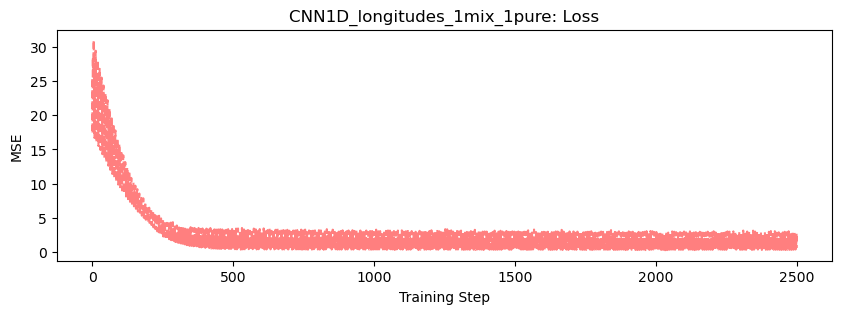

final loss: 0.6425176680832054
model saved to H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/saved_models/CNN1D_longitudes_1mix_1pure.pt
loss curve saved to H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/loss_curves/CNN1D_longitudes_1mix_1pure.png


[25.253832757525593,
 17.337301260797915,
 28.390231433968843,
 25.634031083141537,
 26.152803490471673,
 30.927717134302032,
 27.177544962209804,
 24.067712603136954,
 16.677276425475252,
 27.063059175828144,
 24.686854108075735,
 24.94955597516102,
 29.398545938830132,
 26.09208039174805,
 23.04625414331921,
 16.086999448104997,
 25.841207834478084,
 23.67385067042075,
 23.867037336006028,
 28.007944602099535,
 24.80521766879714,
 21.87488041221605,
 15.503904114512949,
 24.700715065445465,
 22.77840860485676,
 22.828804316015642,
 26.764449085601388,
 23.86949597650489,
 20.891542830543088,
 14.923870113115589,
 23.63622963166853,
 21.918082301851026,
 21.823041649743306,
 25.4802751386256,
 22.724370322692582,
 19.964265078008097,
 14.308803707718194,
 22.48877444393992,
 20.9567474351135,
 20.817189831724832,
 24.32060980756039,
 21.849408389100613,
 19.084104352828074,
 13.779389753685699,
 21.476552126447547,
 20.128655040242627,
 19.91700961809218,
 23.155572918725607,
 20.7467

In [288]:
dropout = 0.5
n_pure_layers = 2
n_mix_layers = 1
n_features = 5
n_channels = n_features * 5
kernel_size = 5

model = CNN1D.CNN1D(
    n_pure_layers=n_pure_layers, 
    n_mix_layers=n_mix_layers, 
    n_features=n_features, 
    n_channels=n_channels,
    kernel_size=kernel_size,
    dropout=dropout
)

save_dir = paths.MODELS_OUTPUT
train.train_model(model, 'CNN1D_longitudes_1mix_1pure', Xt_train, Yt_train, save_dir=save_dir)

device: cpu
device: cpu
Test R^2: 0.988
Test MSE: 0.345


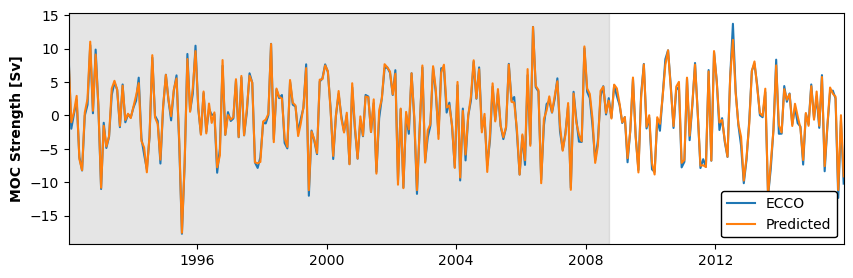

In [289]:
# Extracting all predictions in time order
train_set_pred = train.predict(model, 'CNN1D', Xt_train, Yt_train, save_dir=save_dir)
test_set_pred = train.predict(model, 'CNN1D', Xt_test, Yt_test, save_dir=save_dir)
all_preds = np.concatenate([train_set_pred, test_set_pred])

r2 = round(r2_score(test_set_pred, y_test), 3)
mse = round(mean_squared_error(test_set_pred, y_test), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")

time = outputs.time.values

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

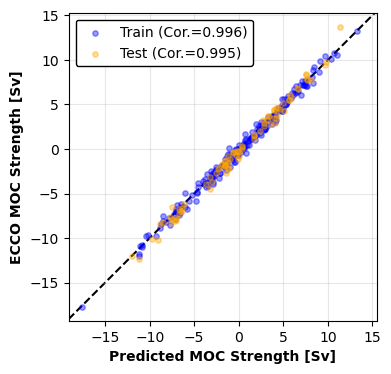

In [290]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(train_set_pred).squeeze()
y_pred_test = np.array(test_set_pred).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()